# CORNETO multicondition undirected prize-collecting steiner trees on CPTAC LUAD Cohort

In this notebook, we illustrate how to run multi-condition prize-collecting steiner trees in undirected graphs using CORNETO. As a case-of-use, we apply it to multi-omics data from the CPTAC Lung Adenocarcinoma cohort (https://doi.org/10.1016/j.cell.2020.06.013). Briefly, we recover a PPI subnetwork that contains as many deregulated proteins as possible across the different patients.


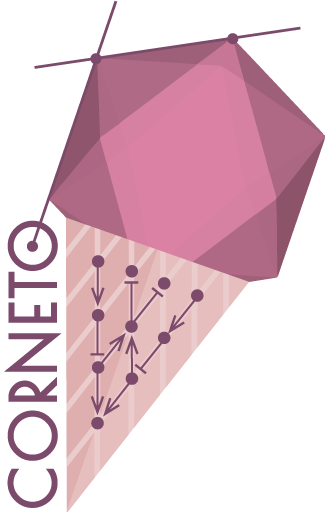

In [1]:
# generic and data science
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

# network handling
import networkx as nx

# supports cptac data download: pip install cptac
import cptac

# corneto
import corneto as cn
from corneto._graph import EdgeType
from corneto.methods.steiner import exact_steiner_tree

seed = 42

random.seed(seed)
np.random.seed(seed)

cn.info()

In [2]:
# load lung adenocarcinoma preprocessed genomics and proteomics data using the cptac package
tumor = cptac.Luad()
prot = tumor.get_proteomics('umich')
muts = tumor.get_somatic_mutation('washu')

array([[<Axes: title={'center': '0'}>]], dtype=object)

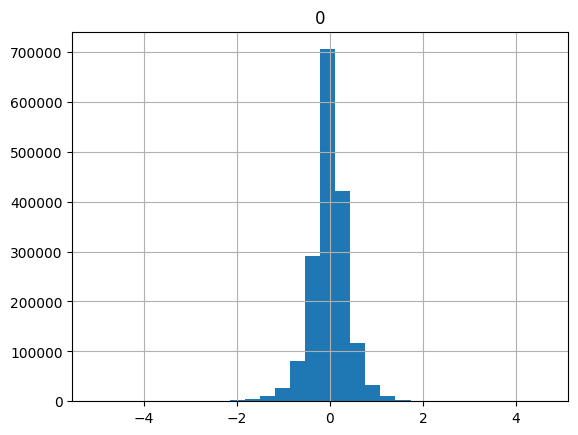

In [3]:
pd.DataFrame(prot.dropna(axis=1).values.flatten()).hist(bins=30)

In [4]:
muts

Name,Gene,Mutation,Location,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,...,ExAC_AC_AN_Adj,ExAC_AC_AN,ExAC_AC_AN_AFR,ExAC_AC_AN_AMR,ExAC_AC_AN_EAS,ExAC_AC_AN_FIN,ExAC_AC_AN_NFE,ExAC_AC_AN_OTH,ExAC_AC_AN_SAS,ExAC_FILTER
Patient_ID,,,,,,,,,,,,,,,,,,,,,
11LU013,NBPF6,Silent,p.E62E,0,.,GRCh38,chr1,108452197,108452197,+,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11LU013,PROK1,Missense_Mutation,p.P52L,0,.,GRCh38,chr1,110454043,110454043,+,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11LU013,UBAP2L,Missense_Mutation,p.D92G,0,.,GRCh38,chr1,154228721,154228721,+,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11LU013,PEAR1,Missense_Mutation,p.T82M,0,.,GRCh38,chr1,156905362,156905362,+,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11LU013,LMX1A,Missense_Mutation,p.R194H,0,.,GRCh38,chr1,165213729,165213729,+,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C3N-02729,H3F3B,Frame_Shift_Ins,p.R18Pfs*80,0,.,GRCh38,chr17,75779122,75779123,+,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C3N-02729,C19orf33,Missense_Mutation,p.E103K,0,.,GRCh38,chr19,38304950,38304950,+,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C3N-02729,TOMM40,Missense_Mutation,p.G357S,0,.,GRCh38,chr19,44903152,44903152,+,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
muts.Mutation.unique()

array(['Silent', 'Missense_Mutation', 'Splice_Site', 'In_Frame_Ins',
       'Frame_Shift_Del', 'In_Frame_Del', 'Nonsense_Mutation',
       'Frame_Shift_Ins', 'Nonstop_Mutation'], dtype=object)

In [6]:
# load the prior knowledge network from omnipath containing PPIs
ppi_df = pd.read_csv('https://omnipathdb.org/interactions?genesymbols=1', sep='\t')
ppi_df

,source,target,source_genesymbol,target_genesymbol,is_directed,is_stimulation,is_inhibition,consensus_direction,consensus_stimulation,consensus_inhibition
0,P0DP23,P48995,CALM1,TRPC1,1,0,1,1,0,1
1,P0DP25,P48995,CALM3,TRPC1,1,0,1,1,0,1
2,P0DP24,P48995,CALM2,TRPC1,1,0,1,1,0,1
3,Q03135,P48995,CAV1,TRPC1,1,1,0,1,1,0
4,P14416,P48995,DRD2,TRPC1,1,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...
81524,P12931,Q9UJM3,SRC,ERRFI1,1,0,0,0,0,0
81525,P43405,Q9ULZ3,SYK,PYCARD,1,0,0,0,0,0
81526,Q14289,Q9ULZ3,PTK2B,PYCARD,1,0,0,0,0,0
81527,P54646,Q9Y2I7,PRKAA2,PIKFYVE,1,0,0,0,0,0


In [7]:
# compute differential proteomic profiles between tumor and normal samples
# subset to patients that have at least 1 tumor and 1 normal sample
meta_df = pd.DataFrame(list(prot.index), columns=['id'])
meta_df['patient_id'] = meta_df['id'].apply(lambda x: re.sub(r'\.N$', '', x))
meta_df['n_obs'] = meta_df.groupby('patient_id')['patient_id'].transform('count')
meta_df['has_normal'] = meta_df.groupby('patient_id')['id'].transform(lambda x: any(x.str.endswith('.N')))
meta_df = meta_df[(meta_df['n_obs'] >= 2) & meta_df['has_normal']].sort_values(by="n_obs")
meta_df

,id,patient_id,n_obs,has_normal
4,C3L-00001,C3L-00001,2,True
139,C3L-02348.N,C3L-02348,2,True
140,C3L-02350.N,C3L-02350,2,True
141,C3L-02365.N,C3L-02365,2,True
142,C3L-02508.N,C3L-02508,2,True
...,...,...,...,...
78,C3N-01413,C3N-01413,2,True
79,C3N-01414,C3N-01414,2,True
80,C3N-01415,C3N-01415,2,True
69,C3N-01021,C3N-01021,2,True


In [8]:
prot = prot.loc[meta_df['id']]

# remove all the proteins not measured in all samples
prot = prot.dropna(axis=1, how='any')

# itearte over unique patients and compute difference between normal and tumor samples
prot_diff = []
for patient_id in meta_df['patient_id'].unique():
    normal_index = meta_df['id'][meta_df['id'].str.contains(patient_id) & meta_df['id'].str.endswith('.N')]
    tumor_index = meta_df['id'][meta_df['id'].str.contains(patient_id) & ~meta_df['id'].str.endswith('.N')]
    normal = prot.loc[normal_index]
    tumor = prot.loc[tumor_index]
    diff = np.array(tumor) - np.array(normal)
    prot_diff.append(pd.DataFrame(diff, columns=[i[0] for i in prot.columns], index=tumor_index))
prot_diff = pd.concat(prot_diff)
prot_diff.reset_index(inplace=True)

# filter to proteins with an absolute log fold change > 0.5 and convert to long format
prot_long = prot_diff.melt(id_vars= ['id'],var_name = 'protein', value_name = 'diff')
avg_prot_diff = prot_long.groupby('protein')['diff'].mean()
int_prots = avg_prot_diff[avg_prot_diff.abs() >= 0.5].index
prot_long = prot_long[prot_long['protein'].isin(int_prots)]
prot_long['abs_diff'] = prot_long['diff'].abs()
prot_long.sort_values('abs_diff', ascending = False, inplace=True)
prot_long

,id,protein,diff,abs_diff
593692,C3N-02000,AGER,-5.467094,5.467094
571248,C3L-00422,WFDC2,5.037893,5.037893
117158,C3N-02379,IGF2BP3,5.031942,5.031942
534876,C3N-01030,S100A2,4.997752,4.997752
593729,C3N-01024,AGER,-4.937303,4.937303
...,...,...,...,...
42172,C3L-01683,RBM28,-0.000152,0.000152
441867,C3L-02365,PKP2,-0.000150,0.000150
618928,C3N-01410,DNAJC2,-0.000143,0.000143
519658,C3N-02582,CD55,-0.000122,0.000122


In [9]:
from sklearn.preprocessing import StandardScaler

prot_abs_diff = prot_long.pivot_table(index='id', columns='protein', values='abs_diff')

# Standardize the data
scaler = StandardScaler()
prot_abs_diff_scaled = scaler.fit_transform(prot_abs_diff)

prot_abs_diff_scaled = pd.DataFrame(prot_abs_diff_scaled, index=prot_abs_diff.index, columns=prot_abs_diff.columns)
prot_abs_diff_scaled.std(axis=1).sort_values(ascending=False)

id
C3L-01330    1.290595
C3N-02089    1.253737
C3L-00093    1.214955
C3L-02345    1.179588
C3L-02508    1.168649
               ...   
C3N-00572    0.719931
C3L-01890    0.714846
C3N-02586    0.714042
C3N-01413    0.682631
C3L-00412    0.661150
Length: 102, dtype: float64

C:\Users\pablo\miniconda3\envs\corneto-dev0\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
C:\Users\pablo\miniconda3\envs\corneto-dev0\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1200x800 with 0 Axes>

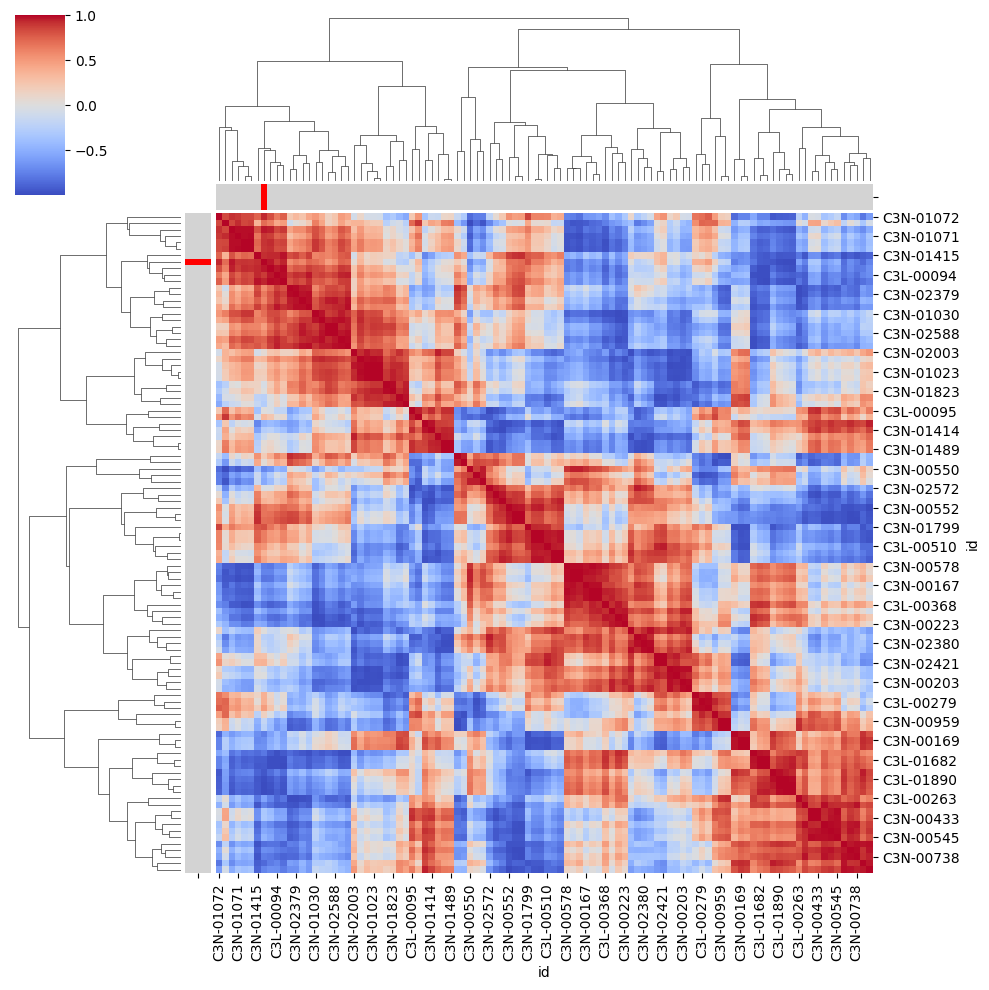

In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Perform PCA
nc = 4
pca = PCA(n_components=nc, random_state=seed)
pca_result = pca.fit_transform(prot_abs_diff_scaled)

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(pca_result, index=prot_abs_diff.index, columns=[f'PC{i+1}' for i in range(nc)])

# Calculate pairwise correlation matrix of PCA components
correlation_matrix = pca_df.T.corr()

sel_patient = prot_abs_diff_scaled.std(axis=1).sort_values(ascending=False).index[0]

# Create a color palette
row_colors = pd.Series(['lightgrey']*correlation_matrix.shape[0], index=correlation_matrix.index)
col_colors = pd.Series(['lightgrey']*correlation_matrix.shape[1], index=correlation_matrix.columns)

# Highlight the specific row and column
row_colors[sel_patient] = 'red'
col_colors[sel_patient] = 'red'

# Create the clustermap
#sns.clustermap(data, row_colors=row_colors, col_colors=col_colors, cmap='viridis')

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(12, 8))
cl = sns.clustermap(correlation_matrix, row_colors=row_colors, col_colors=col_colors, annot=False, cmap='coolwarm')


In [11]:
top_corr_patients = correlation_matrix.sort_values(by=sel_patient, ascending=False).loc[:, sel_patient].head(10)
top_corr_patients

id
C3L-01330    1.000000
C3N-02424    0.966687
C3N-02423    0.961912
C3N-00217    0.942053
C3N-01072    0.931302
C3N-01415    0.915277
C3L-02345    0.904377
C3N-01071    0.891650
C3N-01488    0.890833
C3L-00094    0.879453
Name: C3L-01330, dtype: float64

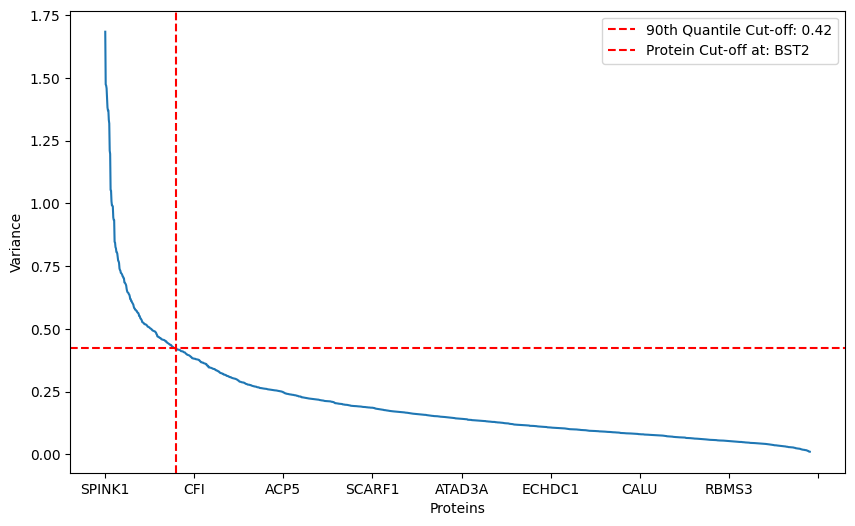

In [12]:
# Most variable proteins in that group of patients (ignoring direction)

qt = 0.90
top_most_var_prots = prot_abs_diff.loc[top_corr_patients.index, :].var(axis=0).sort_values(ascending=False)
quantile_cut_off = top_most_var_prots.quantile(qt)
top_proteins = top_most_var_prots[top_most_var_prots >= quantile_cut_off]

# Calculate the x-position for the vertical line
x_cut_off_name = top_most_var_prots[top_most_var_prots >= quantile_cut_off].index[-1]
x_cut_off = np.flatnonzero(top_most_var_prots.index==x_cut_off_name)[0]

plt.figure(figsize=(10, 6))
top_most_var_prots.plot()
plt.axhline(y=quantile_cut_off, color='r', linestyle='--', label=f'{int(qt*100)}th Quantile Cut-off: {quantile_cut_off:.2f}')
plt.axvline(x=x_cut_off, color='r', linestyle='--', label=f'Protein Cut-off at: {x_cut_off_name}')
plt.title('')
plt.xlabel('Proteins')
plt.ylabel('Variance')
plt.legend()
plt.show()


In [13]:
sel_proteins = top_most_var_prots[top_most_var_prots >= quantile_cut_off]
sel_proteins

protein
SPINK1    1.684564
FTL       1.474645
ADH1C     1.470028
CRABP1    1.458842
MT2A      1.415410
            ...   
ING5      0.424235
TOP2A     0.423934
EFNB2     0.422894
MAP6      0.422078
BST2      0.422031
Length: 159, dtype: float64

In [14]:
# create a dictionary with the number of total missense mutations per gene across the cohort
#muts_global = muts[muts['Mutation'] == 'Missense_Mutation'].groupby('Gene')['Mutation'].count().to_dict()
muts_global = muts[muts['Mutation'] != 'Silent'].groupby('Gene')['Mutation'].count().to_dict()

In [15]:
# create context-specific network, which only contains the proteins that are measured in the differential proteomics data
ppi_net = nx.from_pandas_edgelist(ppi_df, 'source_genesymbol', 'target_genesymbol')
ppi_net = ppi_net.subgraph(set(int_prots)).copy()
largest_cc = max(nx.connected_components(ppi_net), key=len)
ppi_net = ppi_net.subgraph(largest_cc).copy()
print(f"PKN size: {ppi_net.number_of_nodes()}x{ppi_net.number_of_edges()}")

# filter data to nodes in the network (sanity check)
prot_long = prot_long[prot_long['protein'].isin(ppi_net.nodes)]

PKN size: 311x447


In [16]:
# define a function to perform corneto_steiner trees given a graph, a set of terminals and a lambda parameter
def corneto_multicond_st(g, terminals, l, solver_opts=None):
    if solver_opts is None:
        solver_opts = dict(solver="GUROBI", verbosity=1, IntegralityFocus=1, TimeLimit=600, Seed=seed)

    # create corneto graph
    nx_edges = [(u, v) for u, v in g.edges]
    corneto_g = cn.Graph()
    corneto_g.add_edges(nx_edges, type=EdgeType.UNDIRECTED, weight=0.01)

    # prepare and solve the problem
    P = cn.methods.steiner.create_exact_multi_steiner_tree(corneto_g, terminals, strict_acyclic=True, lam=l)
    P.solve(**solver_opts)

    # retrieve selected edges as a networkx graph (union of the steiners per patient)
    sel_edges = set()
    count_v = dict()
    for i in range(len( terminals )):
        flow_edges = np.flatnonzero(np.abs(P.expr['flow' + str(i)].value[:corneto_g.shape[1]]) >= 1e-6)
        vertices = set(corneto_g.edge_subgraph(flow_edges).V)
        for v in vertices:
            count_v[v] = count_v.get(v, 0) + 1
        sel_edges.update(set(flow_edges))

    nx_edges = [(list(i)[0], list(j)[0]) for i, j in corneto_g.edge_subgraph(sel_edges).E]
    nx_output = nx.Graph()
    nx_output.add_edges_from(nx_edges)

    return nx_output, P, corneto_g, count_v

,id,protein,diff,abs_diff
593662,C3L-02345,AGER,-4.907384,4.907384
258307,C3L-01330,PF4,-4.776788,4.776788
134254,C3L-02345,SLC6A4,-4.482200,4.482200
373181,C3N-02423,ITLN1,-3.967596,3.967596
547500,C3N-02424,PRMT6,-3.830705,3.830705
...,...,...,...,...
426844,C3N-01488,TNC,0.006355,0.006355
781026,C3N-00217,STAP2,-0.006120,0.006120
281203,C3N-01071,COL6A2,-0.005136,0.005136
123653,C3L-00094,THBS1,-0.004706,0.004706


In [49]:
def count_keys(cn_input):
    # Count the occurrences of each protein key
    count_inputs = dict()
    for proteins in cn_input.values():
        for protein in proteins.keys():
            if protein not in count_inputs:
                count_inputs[protein] = 0
            count_inputs[protein] += 1
    return count_inputs

In [51]:
# Terminals are top differential proteins
patients = top_corr_patients.index.values
patient_df = prot_long[prot_long['id'].isin(patients)].copy()
patient_df

,id,protein,diff,abs_diff
593662,C3L-02345,AGER,-4.907384,4.907384
258307,C3L-01330,PF4,-4.776788,4.776788
134254,C3L-02345,SLC6A4,-4.482200,4.482200
373181,C3N-02423,ITLN1,-3.967596,3.967596
547500,C3N-02424,PRMT6,-3.830705,3.830705
...,...,...,...,...
426844,C3N-01488,TNC,0.006355,0.006355
781026,C3N-00217,STAP2,-0.006120,0.006120
281203,C3N-01071,COL6A2,-0.005136,0.005136
123653,C3L-00094,THBS1,-0.004706,0.004706


In [53]:
type_input = 0
cn_input = {}

if type_input == 0:
    for id in patient_df.id.unique():
        df_patient_top_prots = patient_df[patient_df.id==id].groupby("protein")[["abs_diff"]].mean().sort_values(by="abs_diff").tail(20)
        df_patient_top_prots[id] = df_patient_top_prots["abs_diff"]
        cn_input.update(df_patient_top_prots[[id]].to_dict())
else:
    cn_df = patient_df[(patient_df.id.isin(patients) & (patient_df.protein.isin(sel_proteins.index)))]
    for id_val, group in cn_df.groupby('id'):
        cn_input[id_val] = group.set_index('protein')['abs_diff'].to_dict()

count_inputs = count_keys(cn_input)
count_inputs

{'CLEC14A': 3,
 'PLAT': 1,
 'COMP': 1,
 'CCDC80': 2,
 'BCAM': 2,
 'PRKG2': 3,
 'PODXL': 1,
 'TNC': 2,
 'DES': 6,
 'COL4A4': 2,
 'THBS2': 4,
 'THBS1': 2,
 'TEK': 2,
 'MMP12': 2,
 'SLC7A5': 5,
 'AQP4': 1,
 'CAV1': 8,
 'CLIC5': 9,
 'AGER': 9,
 'SLC6A4': 6,
 'ANLN': 2,
 'HP': 1,
 'RNF5': 1,
 'SELP': 1,
 'ADD2': 4,
 'HMGA1': 1,
 'F5': 2,
 'FGB': 2,
 'GP1BA': 4,
 'ANK1': 5,
 'FGA': 2,
 'FGG': 2,
 'ITGA2B': 3,
 'SNCA': 6,
 'SLC4A1': 8,
 'PF4': 6,
 'COL5A1': 1,
 'PPP1R14A': 2,
 'CDK1': 1,
 'ABLIM1': 1,
 'KIF2C': 3,
 'SNCG': 3,
 'FOSL2': 2,
 'COL3A1': 2,
 'COL1A1': 2,
 'FGF2': 4,
 'CD34': 4,
 'CD36': 5,
 'ITLN1': 6,
 'TOP2A': 2,
 'MASP2': 2,
 'EFNB1': 1,
 'AKAP12': 1,
 'MYL3': 1,
 'PTN': 3,
 'NEGR1': 2,
 'PRMT6': 1,
 'SPTAN1': 1,
 'F9': 1,
 'MAP2': 1,
 'FCGR2A': 2,
 'COL5A2': 2,
 'VCAN': 1,
 'CKS1B': 2,
 'LAMA3': 3,
 'MCAM': 1,
 'NME1': 1,
 'EZH2': 1,
 'SFTPD': 1,
 'CD93': 1,
 'RRM2': 1,
 'CRYAB': 1,
 'H1-2': 1,
 'SQSTM1': 2,
 'PLA2G4A': 1,
 'H1-4': 1,
 'MASP1': 1,
 'LPL': 1,
 'MBL2': 1,
 'PTPR

In [54]:
all_terminals = {k for subdict in cn_input.values() for k in subdict}
len(all_terminals)

81

In [55]:
result, P, G_pkn, count_v = corneto_multicond_st(ppi_net, cn_input, 0.1)

(447,)
(447,)
(447,)
(447,)
(447,)
(447,)
(447,)
(447,)
(447,)
(447,)
I (10, 447)
OR (447,)
                                     CVXPY                                     
                                     v1.5.2                                    
(CVXPY) Aug 08 09:44:18 AM: Your problem has 22637 variables, 60866 constraints, and 0 parameters.
(CVXPY) Aug 08 09:44:18 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 08 09:44:18 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 08 09:44:18 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Aug 08 09:44:18 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-----------------------------------------------------

C:\Users\pablo\miniconda3\envs\corneto-dev0\Lib\site-packages\cvxpy\problems\problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [56]:
count_v

{'LAMA5': 2,
 'CLEC14A': 3,
 'BCAM': 2,
 'TNC': 5,
 'CDK1': 10,
 'TEK': 2,
 'THBS1': 9,
 'ADD2': 10,
 'F10': 1,
 'CD93': 7,
 'PRKG1': 7,
 'FYN': 10,
 'COL1A1': 3,
 'ITGA3': 6,
 'CCDC80': 2,
 'SLC7A5': 5,
 'COMP': 1,
 'ITGA2B': 10,
 'CAV1': 10,
 'PLG': 1,
 'FGA': 8,
 'PRKCZ': 9,
 'F2': 7,
 'CLIC5': 9,
 'THBS2': 4,
 'AQP4': 1,
 'PLAT': 1,
 'SLC6A4': 6,
 'PTPRB': 3,
 'PRKDC': 10,
 'COL4A4': 2,
 'MMRN2': 1,
 'VCAN': 6,
 'CD36': 6,
 'MMP12': 2,
 'PRKG2': 3,
 'APOH': 1,
 'AGER': 9,
 'DES': 6,
 'PODXL': 1,
 'HMGA1': 10,
 'SELL': 1,
 'PXN': 1,
 'EZH2': 2,
 'RNF5': 1,
 'ANK1': 5,
 'F5': 2,
 'FGB': 2,
 'THBD': 6,
 'CASP3': 2,
 'SNCA': 8,
 'APOA1': 1,
 'ANLN': 2,
 'HP': 1,
 'PF4': 6,
 'JAK2': 1,
 'GP1BA': 5,
 'SELP': 5,
 'SLC4A1': 8,
 'FGG': 2,
 'SNCG': 3,
 'ITGA1': 2,
 'KIF2C': 3,
 'EFNB1': 6,
 'CD34': 4,
 'DAG1': 6,
 'GRK5': 3,
 'COL1A2': 6,
 'FGF2': 4,
 'ITLN1': 6,
 'COL3A1': 2,
 'LAMC1': 6,
 'FOSL2': 2,
 'COL5A1': 2,
 'PPP1R14A': 2,
 'ABLIM1': 1,
 'NCL': 3,
 'MASP2': 2,
 'PRMT6': 1,
 'MBL2': 

In [ ]:
#G_pkn.edge_subgraph(np.flatnonzero(P.expr.flow0_i.value[:G_pkn.shape[1]])).plot()

In [57]:
# Creating the DataFrame
muts_df = pd.DataFrame(muts_global.items(), columns=['Gene', 'n_muts'])
muts_df['group'] = 'Out of\ncontext-specific\nPKN'
muts_df.loc[muts_df['Gene'].isin(ppi_net.nodes), 'group'] = 'In\ncontext-specific\nPKN'
muts_df.loc[muts_df['Gene'].isin(result.nodes), 'group'] = 'In\nSteiner\nTree'

# Define the cutoffs (num. mutations)
cutoffs = range(5, 30)

results = pd.DataFrame()

muts_dfc = muts_df.copy()
#muts_dfc = muts_dfc[~muts_dfc.Gene.isin(all_terminals)]

# Calculate the proportion of highly mutated genes for each cutoff
for cutoff in cutoffs:
    muts_dfc['high_burden'] = muts_df['n_muts'] >= cutoff
    toplot_muts = muts_dfc.groupby('group')['high_burden'].mean().reset_index()
    toplot_muts['cutoff'] = cutoff
    results = pd.concat([results, toplot_muts])

# Reshape the results for plotting
results = results.pivot(index='cutoff', columns='group', values='high_burden')

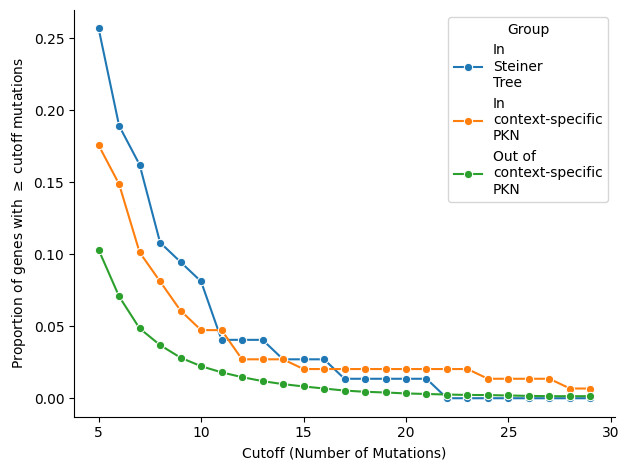

In [58]:
# Plotting the results
for group in results.columns:
    sns.lineplot(x=results.index, y=results[group], marker='o', label=group)

plt.xlabel('Cutoff (Number of Mutations)')
plt.ylabel('Proportion of genes with $\geq$ cutoff mutations')
#plt.title('Proportion of Highly Mutated Genes')
plt.legend(title='Group')

sns.despine()
plt.tight_layout()
plt.savefig("prop_mutations.pdf", format="pdf")

We then visualize the results, highlighting genes with a high mutational load, defined as genes with >= 5 missense mutations in the whole cohort.

In [59]:
muts_sel_patients = muts[muts.index.isin(patients)].copy().reset_index()
muts_sel_patients = muts_sel_patients[~muts_sel_patients.Gene.isin(all_terminals)]
muts_sel_patients = muts_sel_patients[muts_sel_patients.Mutation != "Silent"]
muts_sel_patients = muts_sel_patients[["Patient_ID", "Gene", "Location"]]
muts_sel_patients["mut"] = 1
muts_sel_patients.groupby(["Gene", "Patient_ID"]).sum().sort_values(by="mut", ascending=False).head(20)

,Name,Location,mut
Gene,Patient_ID,,
ZNF256,C3N-02423,p.E464Qp.Q314Hp.R180Tp.E107Q,4
LRP1B,C3N-01071,p.M4497Vp.D3933Ep.L1094F,3
RIMS2,C3N-01415,p.R838Lp.V839Fp.*1350Qext*3,3
TNN,C3N-01415,p.A357Sp.Y381Np.Y1172N,3
MUC16,C3N-02423,p.L13022Vp.S11389Lp.S10790L,3
PAPPA2,C3N-01488,p.P394Tp.P1529Tp.P1592S,3
RYR2,C3N-02423,p.L530Vp.D728Hp.Q2043H,3
KIF26A,C3N-01415,p.G112Vp.S839Ip.G1483S,3
PCDHA7,C3N-00217,p.P360Tp.R415Sp.V535L,3


C:\Users\pablo\AppData\Local\Temp\ipykernel_24268\2930067734.py:19: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter([],[], c=palette[i], label=patient)
C:\Users\pablo\AppData\Local\Temp\ipykernel_24268\2930067734.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


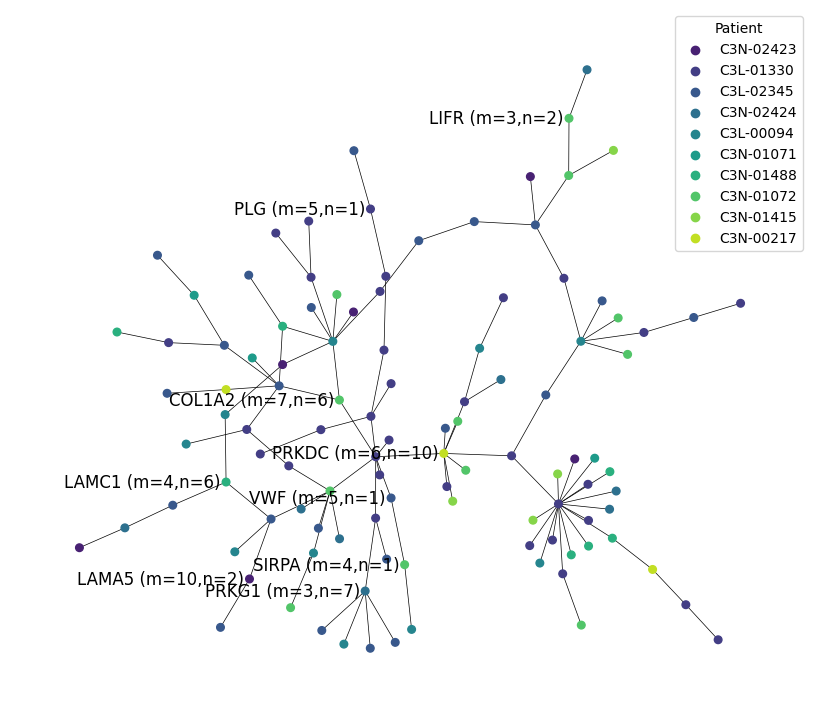

In [60]:
# network visualization using the patient with the maximun absolute fold change per protein to visualize the results
plt.figure(figsize=(8,7))

# group by protein and keep the patient row with maximun abs_diff
top_node_per_patient = patient_df.groupby(['protein'])['abs_diff'].idxmax()
top_df = patient_df.loc[top_node_per_patient]
top_df = top_df[top_df['protein'].isin(result.nodes)]
palette = sns.color_palette('viridis', len(top_df['id'].unique()))
top_df['color'] = top_df['id'].map(dict(zip(top_df['id'].unique(), palette)))
node_colors = [ top_df[top_df['protein'] == node]['color'].values[0] if node in top_df['protein'].values else 'grey' for node in result.nodes ]

# Highlight hubs with at least 5 neighbor proteins
# node_labels = {node: node if len(list(result.neighbors(node))) >= 5 else '' for node in result.nodes}
node_labels = {node: f"{node} (m={(muts_df[muts_df.Gene == node].n_muts.values[0])},n={count_v.get(node,0)}) " if (node in muts_df[muts_df.n_muts >= 3].Gene.values) and node not in all_terminals else '' for node in result.nodes}

l = nx.nx_agraph.graphviz_layout(result)
nx.draw(result, pos=l, node_size = 30,  width = 0.5, node_color = node_colors, labels=node_labels, horizontalalignment='right')
for i, patient in enumerate(top_df['id'].unique()):
    plt.scatter([],[], c=palette[i], label=patient)
plt.legend(title='Patient')
plt.tight_layout()

plt.savefig("patient_subnet.pdf", format="pdf")

In [61]:
all_nodes = result.nodes
all_terminals = set(top_df['protein'])
inferred_nodes = all_nodes - all_terminals
inferred_nodes

set()

While the results should be interpreted with care, it is important to highlight that this network provides a nice basis for further interpretation. The result reduces the space of possible interactions, showing a network more focused on deregulated proteins across patients. This network also includes some inferred nodes, such as PRKDC, which is known to be mutated in ~7% of lung adenocarcinoma patients (in this CPTAC cohort, it has at least one somatic mutations in 7 patients out of 110). When the number of somatic mutations are considered systematically, we observe how our the prize collecting steiner tree is much more enriched in genes with a high mutational load than the background context-specific PPI subnetwork and the original PPI network.